# params

In [1]:
PRFX = 'CVKfld0920-1'
p_o = '../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True)

SEED = 111
K = 5
BS = 40
SZ = 512
FP16 = True
DO_TTA = False

epochs_freeze = 14
epochs_unfreeze = 2

dbg = False
if dbg: dbgsz = 500

In [2]:
'''
get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, 
max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, 
xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]
'''
from fastai.vision import *
params_tfms = dict(     
    max_lighting=0.1,
    max_warp=0,
    max_rotate=0,
    max_zoom=0,)

resize_method = ResizeMethod.PAD
padding_mode = 'zeros'

# setup

In [3]:
from fastai.vision import *
from torchvision.models.resnet import ResNet, Bottleneck
import cv2
from sklearn.model_selection import StratifiedKFold
from fastai.utils.mod_display import *

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

import datetime
def timestr(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

## crop

In [4]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, _ = crop_margin(image)

    image = center_crop(image)

    image = cv2.resize(image, (640, 480))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_yz

## TTTA

In [5]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

# prep

In [6]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [7]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [8]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [9]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']
display(df.shape)
df.target.value_counts()

(3662, 2)

0    1805
2     999
1     370
4     295
3     193
Name: target, dtype: int64

https://www.kaggle.com/chanhu/eye-inference-num-class-1-ver3 LB 0.77

    [0.57, 1.37, 2.57, 3.57]
    2    1226
    0     326
    3     200
    1     152
    4      24

In [10]:
if dbg:
    df = df.head(dbgsz)

In [11]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [12]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz, 
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 8.06 s, sys: 426 ms, total: 8.48 s
Wall time: 6.19 s


CPU times: user 4.39 s, sys: 1.85 s, total: 6.24 s
Wall time: 15.1 s


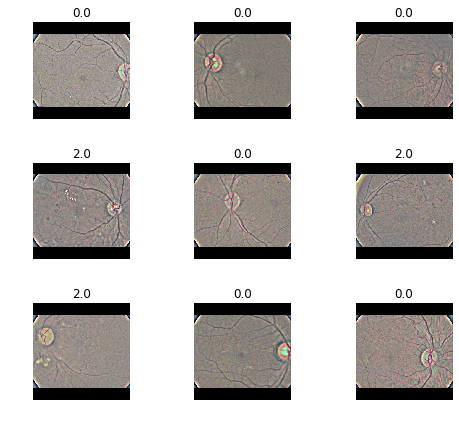

In [13]:
%%time
data.show_batch(rows=3, figsize=(7,6))

## test set

In [14]:
learn = cnn_learner(data, 
                base_arch = models.resnet50, 
                path=p_o)
learn.loss = MSELossFlat
if FP16: learn = learn.to_fp16()


In [15]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [16]:
if dbg:
    df_test = df_test.head(dbgsz)

In [17]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

CPU times: user 576 ms, sys: 672 ms, total: 1.25 s
Wall time: 7.47 s


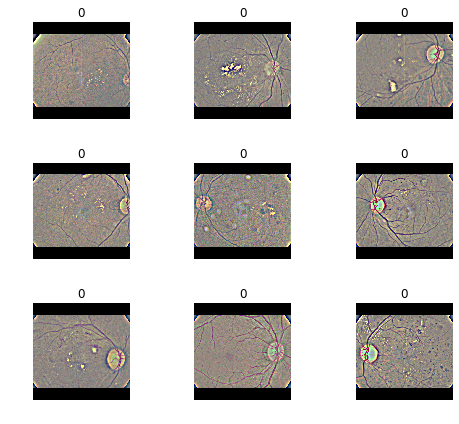

In [18]:
%%time
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Test)

# model

In [19]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 9.36 ms, sys: 81 ms, total: 90.4 ms
Wall time: 1.24 s


In [20]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

# train

## Kfold

In [21]:
skf = StratifiedKFold(n_splits=K)
# for trn_idx, val_idx in skf.split(df, df.target):
#     print(df.target[trn_idx].value_counts())
# for trn_idx, val_idx in skf.split(df, df.target):
#     print(df.target[val_idx].value_counts())
# for trn_idx, val_idx in skf.split(df, df.target):
#     print(val_idx[:10])
# for trn_idx, val_idx in skf.split(df, df.target):
#     print(len(trn_idx), len(val_idx))

In [ ]:
%%time
set_torch_seed()

pred_val  = np.zeros(len(df))
y_val     = np.zeros(len(df))
preds_tst = np.zeros((K, len(df_test)))


for k, (trn_idx, val_idx) in enumerate(skf.split(df, df.target)):
    print(f'[{timestr()}] k:', k)
    df['is_val'] = 0
    df.loc[val_idx, 'is_val']=1
    data = get_data(sz, bs)
    
    learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
    learn.loss = MSELossFlat
    if FP16: learn = learn.to_fp16()
    
    print(f'[{timestr()}] train freeze') 
    set_torch_seed()
    with progress_disabled_ctx(learn) as learn:
        learn.fit_one_cycle(epochs_freeze, max_lr=1e-2, 
                            callbacks=[SaveModelCallback(learn, name=f'bestmodel_frozen_{PRFX}_fld_{k}')])
    
    print(f'[{timestr()}] train unfreeze')
    learn.unfreeze()
    with progress_disabled_ctx(learn) as learn:
        learn.fit_one_cycle(epochs_unfreeze, max_lr=slice(1e-7, 1e-5), 
                            callbacks=[SaveModelCallback(learn, name=f'bestmodel_finetune_{PRFX}_fld_{k}')])
    
    print(f'[{timestr()}] inference val set')
    learn = learn.load('bestmodel_finetune')
    if FP16: learn = learn.to_fp32()

    set_torch_seed()
    with progress_disabled_ctx(learn) as learn:
        pred_val_k, y_val_k = (learn.TTA(ds_type=DatasetType.Valid) if DO_TTA else 
                           learn.get_preds(ds_type=DatasetType.Valid))
    pred_val_k = pred_val_k.numpy().squeeze()
    y_val_k= y_val_k.numpy()

    pred_val[val_idx]=pred_val_k
    y_val[val_idx]=y_val_k
    
    
    print(f'[{timestr()}] inference test set')
    set_torch_seed()
    learn.data.add_test(
        ImageList.from_df(df_test,
        '../input/aptos2019-blindness-detection',
        folder='test_images',
        suffix='.png'))
    with progress_disabled_ctx(learn) as learn:
        pred_tst_k, _ = (learn.TTA(ds_type=DatasetType.Test) if DO_TTA else 
                   learn.get_preds(ds_type=DatasetType.Test))
    pred_tst_k = pred_tst_k.numpy().squeeze()
    preds_tst[k] = pred_tst_k
    
    del learn
    gc.collect()
    
    

In [ ]:
pred_tst = preds_tst.mean(0)

# rounder

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [ ]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [ ]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(pred_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

In [ ]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(pred_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

In [ ]:
optnm2coefs

In [ ]:
optnm2preds_val_grd = {k: bucket(pred_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [ ]:
optnm2qwk

In [ ]:
Counter(y_val).most_common()

In [ ]:
pred_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [ ]:
pred_val_grd.mean()

In [ ]:
Counter(pred_val_grd).most_common()

In [ ]:
list(zip(pred_val_grd, y_val))[:10]

In [ ]:
(pred_val_grd== y_val.squeeze()).mean()

In [ ]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [ ]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    pred_val_grd = bucket(pred_val, coef)
    display(pd.Series(pred_val_grd.squeeze().astype(int)).value_counts())

# testing

In [ ]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    pred_tst_grd = bucket(pred_tst, coef)
    display(pd.Series(pred_tst_grd.squeeze().astype(int)).value_counts())

In [ ]:
coef = optnm2coefs['simple']
pred_tst_grd = bucket(pred_tst, coef)
pd.Series(pred_tst_grd.squeeze().astype(int)).value_counts()


## submit

In [ ]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = pred_tst_grd.squeeze().astype(int)
subm.head()

In [ ]:
subm.diagnosis.value_counts()

In [ ]:
subm.to_csv(f"{p_o}/submission.csv", index=False)